In [217]:
import torchvision
import torchvision.transforms as transforms
import torch
from matplotlib import pyplot as plt
import numpy as np

In [218]:
transform = transforms.ToTensor()

batch_size = 128

trainset = torchvision.datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

print("trainset:", len(trainset))
print("testset:", len(testset))


trainset: 60000
testset: 10000


In [219]:
# Shape of an example
print(f"Shape: {len(trainset[0][0][0])}, {len(trainset[0][0][0][0])}")

Shape: 28, 28


In [220]:
# All labels in training set
classes = set([y for _, y in trainset])
classes

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [221]:
# Function to show images
def show_imgs(imgs):
    imgs_data = [img for img, _ in imgs]
    imgs_label = [label for _, label in imgs]
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(imgs_data):
        plt.subplot(1, len(imgs_data), i+1)
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("Labels:", imgs_label)

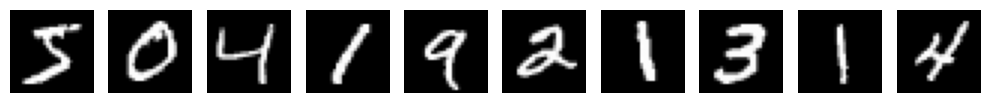

Labels: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [222]:
sample_imgs = [trainset[i] for i in range(10)]
show_imgs(sample_imgs)

In [387]:
class MNISTClassifier:
    def __init__(self, loss_fn, input_dim=784, hidden_dim=128, output_dim=10):
        self.loss_fn = loss_fn

        scale = 0.01
        self.W1 = torch.tensor(np.random.randn(hidden_dim, input_dim) * scale, requires_grad=True)
        self.W2 = torch.tensor(np.random.randn(output_dim, hidden_dim) * scale, requires_grad=True)

        # internal biases for respective layers
        self.w1 = torch.zeros(hidden_dim, requires_grad=True)
        self.w2 = torch.zeros(output_dim, requires_grad=True)

        # prediction biases
        self.b1 = torch.zeros(hidden_dim, requires_grad=True)

        self.current_loss = None

    def forward(self, x):
        h1 = self.W1 @ x + self.w1
        y1 = torch.relu(h1) + self.b1
        h2 = self.W2 @ y1 + self.w2
    
        y2 = torch.softmax(h2, dim=0)
        return y2

    def backward(self, x, y_true):
        # Forward pass
        h1 = self.W1 @ x + self.w1
        y1 = torch.relu(h1) + self.b1
        h2 = self.W2 @ y1 + self.w2
        y2 = torch.softmax(h2, dim=0)
    
        # Compute gradients
        dy2 = y2.clone()
        dy2[y_true] -= 1
    
        # Gradients for second layer 
        dW2 = torch.outer(dy2, y1)
        dw2 = dy2
        
        # First layer gradients
        dy1 = self.W2.T @ dy2 
        dh1 = dy1 * (h1 > 0).float()  # ReLU derivative
        dW1 = torch.outer(dh1, x)
        dw1 = dh1
        db1 = dy1
    
        # Update weights
        lr = 0.0001
        with torch.no_grad():
            self.W2 -= lr * dW2
            self.w2 -= lr * dw2
            self.W1 -= lr * dW1
            self.w1 -= lr * dw1
            self.b1 -= lr * db1
            
    def calculate_loss(self, y_pred, y_true):
        self.current_loss = self.loss_fn(y_pred, y_true)
        return self.loss_fn(y_pred, y_true)

In [388]:
# Shape of single exanple
trainset[0][0].shape # requires reshaping to 784 features

x = torch.tensor(np.float64(trainset[0][0].reshape(784)))

In [389]:
# Dummy model (untrained)
dummy = MNISTClassifier(loss_fn=None)
dummy_out = dummy.forward(x) # outputs probabilities for each class
dummy_out

tensor([0.0998, 0.1004, 0.0994, 0.1002, 0.0996, 0.0989, 0.0999, 0.1005, 0.0996,
        0.1018], dtype=torch.float64)

In [390]:
# Define loss functions
def cross_entropy_loss(out, y):
    """
    idea: softmax outputs very small values (probabiltiies) for each class:
        - take log of values to get bigger values (negative)
        - take negative of log to get positive values
        - if out[y] = 0, then -log(out[y]) = inf, so add a small value to avoid this
    """
    y_ohe = torch.zeros_like(out)
    y_ohe[y] = 1.0

    return -torch.sum(y_ohe * torch.log(out +1e-10))

def mse_loss(out, y):
    out_ohe = np.zeros_like(out)
    return np.sum((out_ohe - y)**2)

In [391]:
model = MNISTClassifier(loss_fn=cross_entropy_loss)
out = model.forward(x)
out

tensor([0.1005, 0.1004, 0.0994, 0.1006, 0.1006, 0.0997, 0.1010, 0.0995, 0.0994,
        0.0989], dtype=torch.float64)

In [392]:
# Test the loss function
model.calculate_loss(out, trainset[0][1]).item()

2.305269302039126

In [393]:
epochs = 1
all_losses = {
    "epoch": [1],
    "loss": []
}

# Classic old gradient descent
for epoch in range(epochs):
    epoch_loss = 0
    
    for i in range(len(trainset)):
        img, label = trainset[i]
        x = torch.tensor(np.float64(img.reshape(784)))
        
        output = model.forward(x)
        
        loss = model.calculate_loss(output, label)
        epoch_loss += loss
        
        model.backward(x, label)
        
        if i % 1000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')
    
    avg_loss = epoch_loss / len(trainset)
    all_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

Epoch [1/1], Step [0/60000], Loss: 2.3053
Epoch [1/1], Step [1000/60000], Loss: 2.2998
Epoch [1/1], Step [2000/60000], Loss: 2.3026
Epoch [1/1], Step [3000/60000], Loss: 2.3097
Epoch [1/1], Step [4000/60000], Loss: 2.2925
Epoch [1/1], Step [5000/60000], Loss: 2.2967
Epoch [1/1], Step [6000/60000], Loss: 2.2883
Epoch [1/1], Step [7000/60000], Loss: 2.3090
Epoch [1/1], Step [8000/60000], Loss: 2.2576
Epoch [1/1], Step [9000/60000], Loss: 2.2942
Epoch [1/1], Step [10000/60000], Loss: 2.2767
Epoch [1/1], Step [11000/60000], Loss: 2.2587
Epoch [1/1], Step [12000/60000], Loss: 2.2761
Epoch [1/1], Step [13000/60000], Loss: 2.2769
Epoch [1/1], Step [14000/60000], Loss: 2.2632
Epoch [1/1], Step [15000/60000], Loss: 2.3257
Epoch [1/1], Step [16000/60000], Loss: 2.2838
Epoch [1/1], Step [17000/60000], Loss: 2.2539
Epoch [1/1], Step [18000/60000], Loss: 2.3003
Epoch [1/1], Step [19000/60000], Loss: 2.2801
Epoch [1/1], Step [20000/60000], Loss: 2.3236
Epoch [1/1], Step [21000/60000], Loss: 2.2590
E

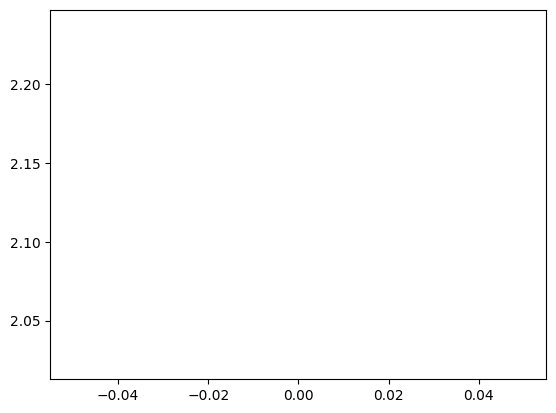

In [395]:
plt.plot(all_losses)